### Note:

This is **the second version** of the final project. Below is the list of modifications I made from the first version.

- Created a new feature "eso_expenses" = expenses / exercised_stock_options
- Explained the scaling method I employed for the project more explicitly.
- Modified **GridSearchCV** scroing parameter to **f1**. By default, it tries to maximize accuracy and we can get a high accuracy just by assuming everyone is non-POI.
- **GridSearchCV** was run multiple times over cross validation iterations. To fix this, I took the best parameters from **GridSearchCV** and fixed those parameters in the model.
- **Linear Regression** and **Lasso Regression** are used when we have a continuous output. However, in this project, the output is discrete values: POI or non-POI. **Logistic Regression** is the algorithm that is appropriate to use.
- Used **Recursive Feature Elmination (RFE)** to quickly elminate low ranking features.
- Used **feature importances** in a Decision Tree to filter the low ranking features further.
- Answers to the project questionnaire in the **final thoughts** section.


# Identifying POI from Enron Dataset
### Final Project - Machine Learning Course
### Udacity Data Analyst Nanodegree

This is the final project for the machine learning course. Enron financial data and email data will be investigated to find the list of person of interest (POI) who were involved in the fraud activities.

Below is the order of the investigation process I will employ for this final project.
- Univariate analysis
    - Process the dataset (taking care of missing values and outliers)
    - Select good features that don't have too many zeros or missing values
    - Calculate accuracy, precision and recall for each feature I selected using classifiers with default parameters.
- Bivariate analysis 
    - Use features that show the high scores from the univariate analysis
    - Calculate accuracy, precision and recall from a pair of features using more classifiers and various parameters.
- Multivariate analysis
    - Calculate accuracy, precision and recall from features with the best scores from univariate and bivariate analysis.

In the end, I will choose the combination of features and classifier that shows the best scores.

First, necessary Libraries will be loaded.

In [207]:
#!/usr/bin/python

import sys
import pickle
import pprint
import matplotlib.pyplot as plt
import numpy as np

### Setting the path
sys.path.append("../tools/")

### These are the scripts given in the class
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

Load the dictionary containing the dataset.

In [208]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [209]:
len(data_dict)

146

There are total 146 number of data in data_dict. I am going to print out the first two of the data from data_dict to see how the dictionary looks like.

In [210]:
stop = 0
for k, v in data_dict.iteritems():
    print k
    pprint.pprint(v)
    if stop == 1:
        break
    stop += 1

METTS MARK
{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}
BAXTER JOHN C
{'bonus': 1200000,
 'deferral_payments': 1295738,
 'deferred_income': -1386055,
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 6680544,
 'expenses': 11200,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 1586055,
 'other': 2660303,
 'poi': False,
 'restricted_stock': 3942714,
 'rest

The keys of data_dict are the names of people and the values are various features. Every feature except poi and email_address are numerical values. It looks like it is either a number of 'NaN' when the data is missing. And poi is a boolean value that I can use to find POI's.

In [211]:
### Finding the number of features
for k,v in data_dict.iteritems():
    print "The number of features:", len(v)
    features_list = v.keys() # features are saved separately for later use
    break

The number of features: 21


There are total 21 features in the dataset. I will ignore "email_address" because they are not numerical values. And I will ingore 'other' as well because I don't know what this is.

In [212]:
### Removing poi and email_address
try:
    features_list.remove("email_address")
    features_list.remove("other")
except:
    pass

### Convert data_dict into numpy array
data = featureFormat(data_dict, features_list)
print "The type of data:", type(data)
print "The total number of data", data.shape

The type of data: <type 'numpy.ndarray'>
The total number of data (145L, 19L)


Now the data_dict is converted to numpy array. And it contains 145 rows and 19 columns. 
featureFormat ignores the "NaN" values and creates numpy array that I can use it for the analysis more easily.

Using data numpy array I will check the number of poi's and non-poi's.

In [213]:
### Finding the index of poi
poi_ind = features_list.index("poi")

### Print out the number of poi and non-poi
print "The total number of poi:", np.sum(data[:,poi_ind])
print "The total number of non-poi:", np.size(data[:,poi_ind]) - np.sum(data[:,poi_ind])

The total number of poi: 18.0
The total number of non-poi: 127.0


There are total 18 POI and 127 non-POI.

In [214]:
### Move poi column to the end
### data
tmp_data = data
tmp_data[:,-1] = data[:,poi_ind]
tmp_data[:,poi_ind] = data[:,-1]
data = tmp_data

### features_list
tmp = features_list[-1]
features_list[poi_ind] = tmp
features_list[-1] = "poi"

### Reassign poi index
poi_ind = features_list.index("poi")

I moved poi column to the end to use the data more easily.

## Plotting

From now on, I will start drawing various plots for univariate analysis and bivariate analysis.
I will draw histograms for each feature first.

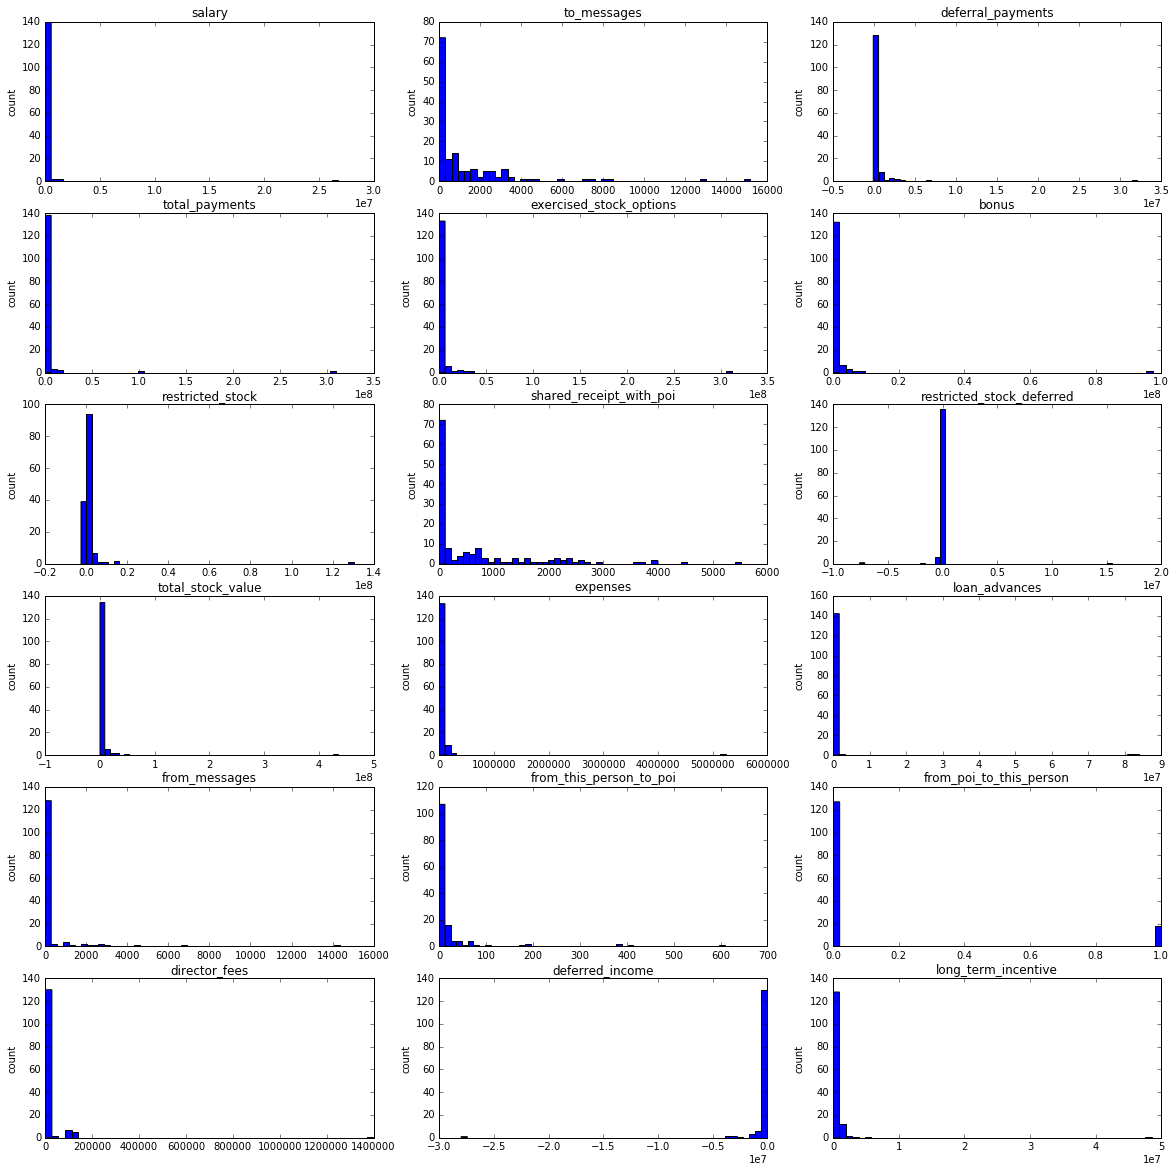

In [215]:
### Create new features list without poi
features_list_new = [ii for ii in features_list if ii != "poi"]

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

Above diagrams show 19 histograms. I first created new list of features excluding poi because array of poi consists of only true or false so it won't provide an insightful histogram. 

Looking at these histograms, I can see there are outliers for every feature.

I will look into salary more deeply and see if there is any interesting thing going on.

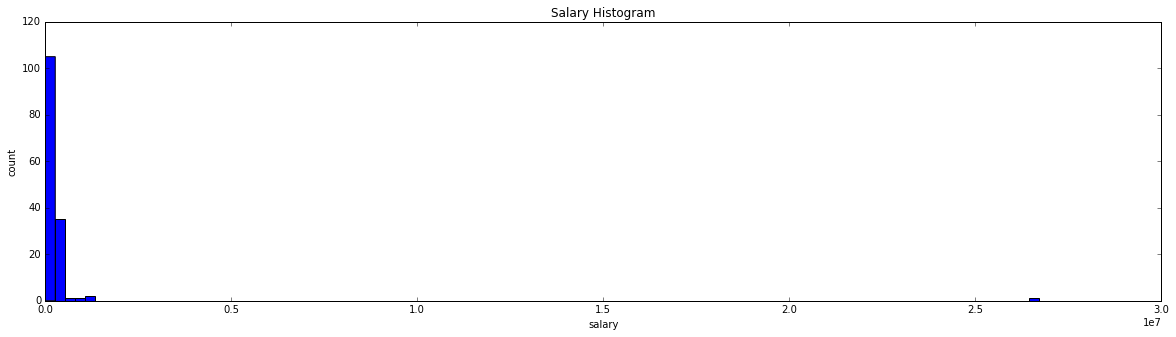

In [216]:
%matplotlib inline
### Find indices for salary
salary_ind = features_list.index("salary")

### Set the size of the plot
plt.rcParams["figure.figsize"] = (20,5)

### Draw Salary histogram
plt.hist(data[:,salary_ind], bins=100)
plt.xlabel("salary")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

Now I will get rid of the outlier above 2.5e7 and replot the histogram

53408458.0 is the total sum of salaries
26704229.0 is removed


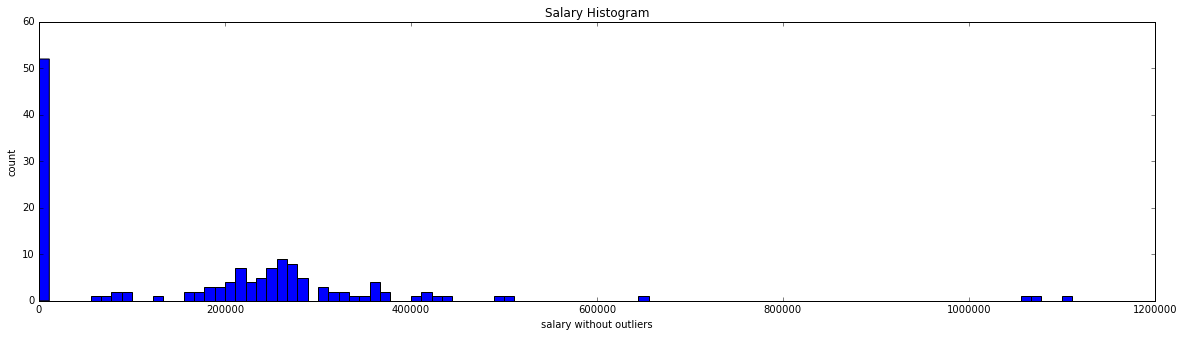

In [217]:
### Total sum of salaries
import numpy as np
print np.sum(data[:,salary_ind]), "is the total sum of salaries"

### Create new array that contains salar values without outliers
salary_no_outliers = []
for i in data[:,salary_ind]:
    if i < 2.5e7:
        salary_no_outliers.append(i)
    else:
        print i, "is removed"

### Draw Salary histogram
plt.hist(salary_no_outliers, bins=100)
plt.xlabel("salary without outliers")
plt.ylabel("count")
plt.title("Salary Histogram")
plt.show()

The outlier removed is half of the total sum of salary array, which means someone added a total sum of salaries into the data. I believe that in data_dict there is a key that contains the sum of every feature.

In [218]:
for k,v in data_dict.iteritems():
    if v["salary"] == 26704229.0:
        print k,v

TOTAL {'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


As I expected one of the keys in data_dict is TOTAL. I will create a new dictionary that excludes this key.

In [219]:
### New data_dict excluding TOTAL key
data_dict_new = {}

for k, v in data_dict.iteritems():
    if k != "TOTAL":
        data_dict_new[k] = v

### Print out the new data_dict length
print "The length of the new data_dict:", len(data_dict_new)
    

The length of the new data_dict: 145


Now there are 145 data in the data_dict_new. I will graph the histograms again.

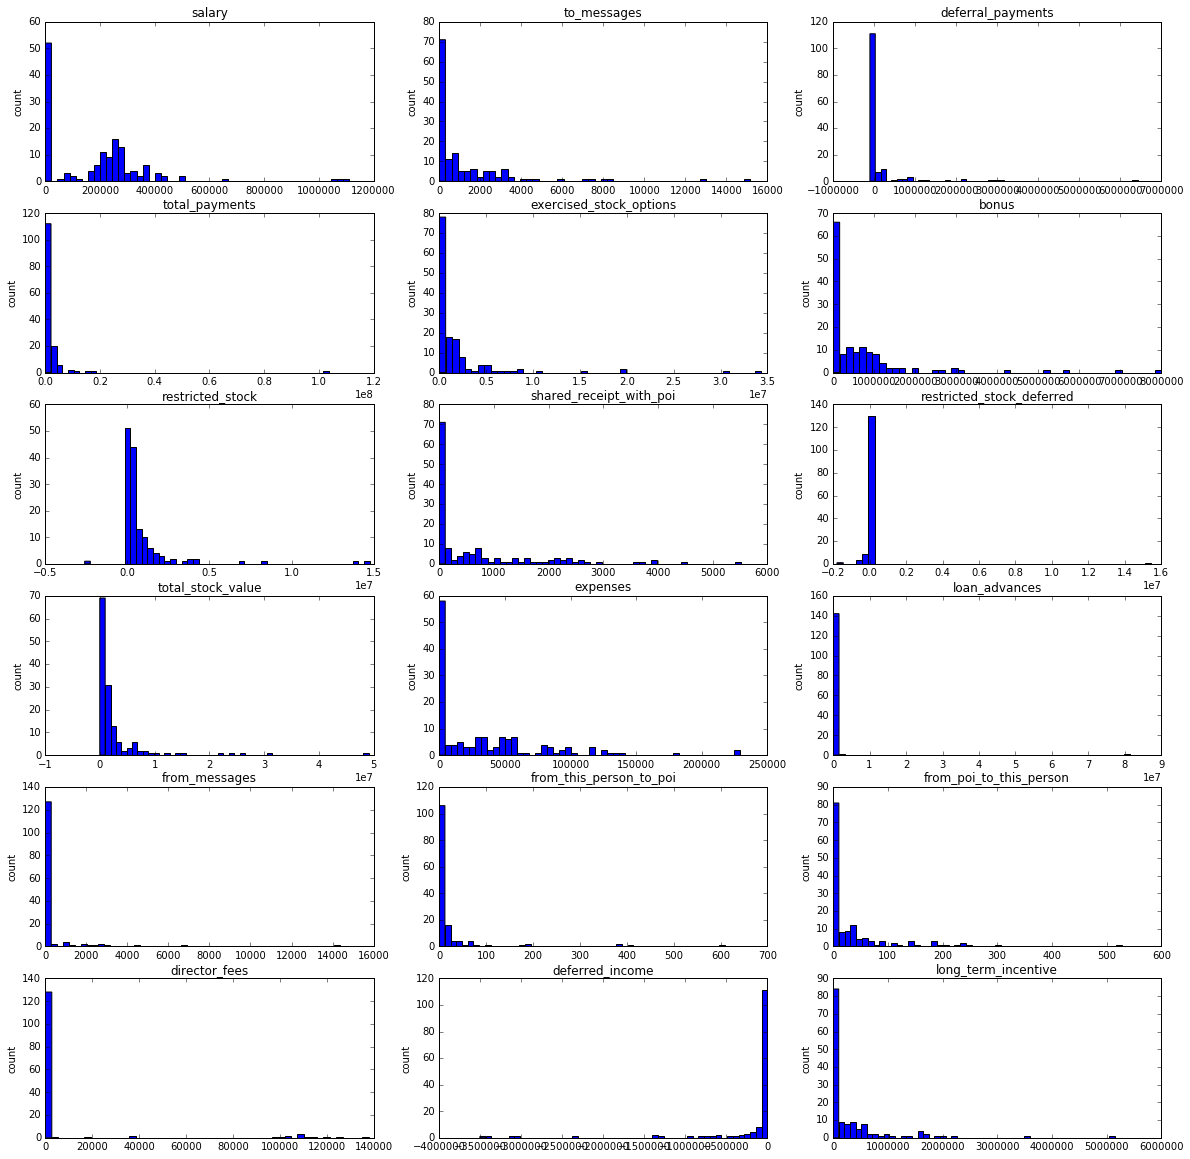

In [220]:
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)

%matplotlib inline
### 20 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(6, 3)

### the histogram of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_histogram(x, bins, r, c, title):
    axarr[r, c].hist(x, bins = bins)
    axarr[r, c].set_title(title)
    axarr[r, c].set_ylabel("count")

for i in range(len(features_list_new)):
    subplot_histogram(data[:,i],50,i/3,i%3,features_list_new[i])

plt.show()

The histograms are better than before. Although there are still outliers in histograms, getting rid of them might not be a good idea because those values may be helpful identifying POI's.

I suspect that some of these features will have too many zeros because featureFormat function convert NaN to zero in some cases. I will print out the number of zeros for each feature. 

In [221]:
### defining function that counts zeros
def counting_zeros(data, features_list, feature):
    total_count = 0
    count = 0
    feature_data = data[:,features_list.index(feature)]
    for i in feature_data:
        total_count += 1
        if i == 0:
            count += 1
    print "{}: {}, {}%".format(feature,count, int(float(count)*100/float(total_count)))

### Printing out the number of zeros for each feature
for i in features_list[:-1]:
    counting_zeros(data, features_list, i)

salary: 50, 34%
to_messages: 58, 40%
deferral_payments: 106, 73%
total_payments: 20, 13%
exercised_stock_options: 43, 29%
bonus: 63, 43%
restricted_stock: 35, 24%
shared_receipt_with_poi: 58, 40%
restricted_stock_deferred: 127, 88%
total_stock_value: 19, 13%
expenses: 50, 34%
loan_advances: 141, 97%
from_messages: 58, 40%
from_this_person_to_poi: 78, 54%
from_poi_to_this_person: 70, 48%
director_fees: 128, 88%
deferred_income: 96, 66%
long_term_incentive: 79, 54%


I will ignore features with more than 60% of zeros from now on.

### Features that will be ignored:
- deferral_payments
- restricted_stock_deferred
- loan_advances
- director_fees
- deferred_income

I will recreate data numpy array and features_list array that exclude the features above.

In [222]:
### Save the original features_list before change
features_list_original = features_list

### list of features with too many zeros
too_many_zeros = ["deferral_payments", 
                  "restricted_stock_deferred",
                  "loan_advances",
                  "director_fees",
                  "deferred_income"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print data.shape

(144L, 14L)


Now the number of columns of data is reduced to 14.

### Checking Scores

Now I am going to test each feature using GaussianNB and check the accuracy, precision and recall. Then I will use features with high values for later use.

I will employ tester functions from tester.

In [223]:
### Import functions from tester_edited.py
from tester_edited import load_classifier_and_data, test_classifier
from sklearn.cross_validation import StratifiedShuffleSplit

This will be a repetitive process so I will create a function to do this.

In [224]:
### the code is from "poi_id.py" from final_project folder.
### this function will split the data into test and train
### apply classifier and calculate the accuracy, precision and recall
def test(features_list, clf, print_result=False, draw_graph=False, rescale=False):
    ### Store to my_dataset for easy export below.
    my_dataset = data_dict
    
    ### Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
#     ### Split train and test by 30 %
#     from sklearn.cross_validation import train_test_split
#     features_train, features_test, labels_train, labels_test = \
#         train_test_split(features, labels, test_size=0.3, random_state=42)
        
    ### Dump the data to the local files
    dump_classifier_and_data(clf, my_dataset, features_list)
    
    ### Load the data from the local files
    clf, dataset, feature_list = load_classifier_and_data()
    
    ### Print out the result
    scores = test_classifier(
        clf, dataset, feature_list, 
        print_result=print_result, draw_graph=draw_graph, rescale=rescale)
    return scores

### import GaussianNB
from sklearn.naive_bayes import GaussianNB

### import Decision Tree
from sklearn import tree

### This function only test the data using
### GaussianNB and Decision Tree
def classify_simple(features_list, print_result=False):
    print "Features list:", features_list[1:]
    
    ### Set GaussianNB
    clf_NB = GaussianNB()

    ### Set Decision Tree
    clf_tree = tree.DecisionTreeClassifier()
    
    ### Call test function and print out test
    scores_NB = test(features_list,clf_NB, print_result=print_result)
    tree_NB = test(features_list,clf_tree, print_result=print_result)
    return [ scores_NB, tree_NB ]

I created a function that can show the accuracy, precision and recall values from features list input. The test function is mainly from the "poi-id.py" file from the final project folder. I creates clf for classifier, features list and dataset so that it can be loaded in test_classifier function in "tester.py" file. Note that the validation used in this code is Train/Test split. The purpose is not to get the largest scores but to select features that show the high scores compared to the others. So I don't use other cross validation for now. For the same reason, I don't specify any parameter for classifiers. The parameters will be adjusted at a later section.

In [225]:
### Always put poi at the zeroth index
classify_simple(["poi", "salary"],print_result=True)

Features list: ['salary']

GaussianNB()

	Best parameters:
	No GridSearch

	Accuracy: 0.25560	Precision: 0.18481	Recall: 0.79800	F1: 0.30011	F2: 0.47968
	Total predictions: 20000	True positives: 3192	False positives: 14080	False negatives:  808	True negatives: 1920


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

	Best parameters:
	No GridSearch

	Accuracy: 0.69210	Precision: 0.23619	Recall: 0.24150	F1: 0.23881	F2: 0.24042
	Total predictions: 20000	True positives:  966	False positives: 3124	False negatives: 3034	True negatives: 12876



[[0.2556, 0.18480778138026865, 0.798], [0.6921, 0.23618581907090463, 0.2415]]

I ran the function using poi and salary. Fortunately the function works.

I will use this function for all the other features.

In [226]:
### Iterate over the features_list
scores_list = {}
for i in features_list[:-1]:
    scores_list[i] = classify_simple(["poi", i])

Features list: ['salary']
Features list: ['to_messages']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['total_payments']
Features list: ['exercised_stock_options']
Features list: ['bonus']
Features list: ['restricted_stock']
Features list: ['shared_receipt_with_poi']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['total_stock_value']
Features list: ['expenses']
Features list: ['from_messages']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['from_this_person_to_poi']
Got a divide by zero when trying out: GaussianNB()
Precision or recall may be undefined due to a lack of true positive predicitons.

Features list: ['from_poi_to_this_person']
Features list: ['long_term_incentive']


In [227]:
### Print out scores of each feature
print "      Accuarcy Precision Recall"
for k,v in scores_list.iteritems():
    print k
    if v[0] == None:
        print "NB     ---------None---------"
    else:
        print "NB     {0:.4f}  {1:.4f}  {2:.4f}".format(v[0][0], v[0][1], v[0][2])
    print "tree   {0:.4f}  {1:.4f}  {2:.4f}".format(v[1][0], v[1][1], v[1][2])

      Accuarcy Precision Recall
salary
NB     0.2556  0.1848  0.7980
tree   0.6921  0.2362  0.2415
to_messages
NB     ---------None---------
tree   0.7371  0.0856  0.1410
total_payments
NB     0.7631  0.0694  0.0435
tree   0.7393  0.0804  0.0665
bonus
NB     0.3780  0.2223  0.7200
tree   0.7623  0.4427  0.2685
total_stock_value
NB     0.8406  0.3200  0.0320
tree   0.7584  0.2300  0.2430
shared_receipt_with_poi
NB     ---------None---------
tree   0.8421  0.3020  0.3210
exercised_stock_options
NB     0.8994  0.2108  0.0390
tree   0.8571  0.2686  0.3320
from_messages
NB     ---------None---------
tree   0.7259  0.0067  0.0100
from_this_person_to_poi
NB     ---------None---------
tree   0.7444  0.0218  0.0180
long_term_incentive
NB     0.3980  0.1471  0.6700
tree   0.6943  0.0250  0.0300
expenses
NB     0.3068  0.1885  0.7460
tree   0.6466  0.1295  0.1340
restricted_stock
NB     0.7380  0.1013  0.0560
tree   0.7297  0.1196  0.0765
from_poi_to_this_person
NB     0.7365  0.0263  0.0015
tree

Notice that those features where NB score is zero have zeros more than 50%. Initially I thought removing features with zeros more than 60% might be sufficient but apparently I should have set my threshold to be 60% instead of 50%.

And I will remove total_payments from my list because this feature has precision and recall values less than 1%.

In [228]:
### list of features with too many zeros above 50%
too_many_zeros = ["to_messages",
                  "shared_receipt_with_poi",
                  "from_messages",
                  "from_this_person_to_poi",
                  "total_payments"]

### remove the above features from features_list
for i in too_many_zeros:
    if i in features_list:
        features_list.remove(i)
        
### Convert data_dict_new into numpy array
data = featureFormat(data_dict_new, features_list)
print "Shape of data:", data.shape
pprint.pprint(features_list)

Shape of data: (139L, 9L)
['salary',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'total_stock_value',
 'expenses',
 'from_poi_to_this_person',
 'long_term_incentive',
 'poi']


The number of columns are reduced to 9 including poi. Let's print the result again only from these features.

In [229]:
### Print out scores of each feature
print "      Accuarcy Precision Recall"
for k,v in scores_list.iteritems():
    if k in features_list:
        print k
        if v[0] == None:
            print "NB     ---------None---------"
        else:
            print "NB     {0:.4f}  {1:.4f}  {2:.4f}".format(v[0][0], v[0][1], v[0][2])
        print "tree   {0:.4f}  {1:.4f}  {2:.4f}".format(v[1][0], v[1][1], v[1][2])

      Accuarcy Precision Recall
salary
NB     0.2556  0.1848  0.7980
tree   0.6921  0.2362  0.2415
bonus
NB     0.3780  0.2223  0.7200
tree   0.7623  0.4427  0.2685
total_stock_value
NB     0.8406  0.3200  0.0320
tree   0.7584  0.2300  0.2430
exercised_stock_options
NB     0.8994  0.2108  0.0390
tree   0.8571  0.2686  0.3320
long_term_incentive
NB     0.3980  0.1471  0.6700
tree   0.6943  0.0250  0.0300
expenses
NB     0.3068  0.1885  0.7460
tree   0.6466  0.1295  0.1340
restricted_stock
NB     0.7380  0.1013  0.0560
tree   0.7297  0.1196  0.0765
from_poi_to_this_person
NB     0.7365  0.0263  0.0015
tree   0.6425  0.1312  0.0765


From the result above, the features with the best scores are **bonus**, **exercised_stock_options** and **total_stock_value**.
I will use these features as my main dependent variables for the bivariate analysis.

## Bivariate Analysis

In bivariate analysis section, I will investigate the relationship between two features.
Below is the list of pairs of features I am going to see.

**Pairs of Best features**
- bonus and exercised_stock_options
- bonus and total_stock_value
- exercised_stock_options and total_stock_value

**Best features and others** *x is bonus, exercised_stock_options or total_stock_value*
- x and salary
- x and restricted_stock
- x and expenses
- x and from_poi_to_this_person
- x and long_term_incentive

There are total 18 scatter plots. For each scatter plot, if I see something interesting, I will use Naive Bayes and SVM (rdf) to see the accuracy, precision and recall.

At the end of this section, I will gather the pairs of features with high positive correlation for PCA. I will combine the pairs of features with the largest accuracy and use them for the further analysis.

### Bonus and Exercised Stock Options

I will first check the relationship between bonus and exercised_stock_options by graphing a scatter plot.

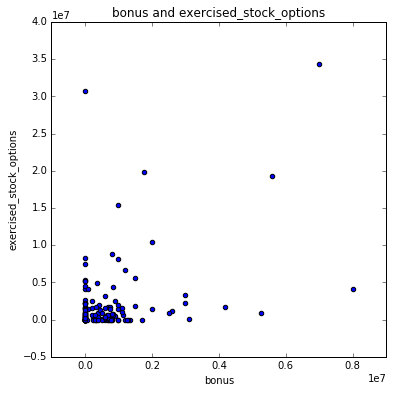

In [230]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### Draw Salary histogram
plt.scatter(data[:,features_list.index("bonus")], data[:,features_list.index("exercised_stock_options")])
plt.xlabel("bonus")
plt.ylabel("exercised_stock_options")
plt.title("bonus and exercised_stock_options")
plt.show()

I will add colors to this scatter plot. I will color the points from poi to be red and the others to be blue.

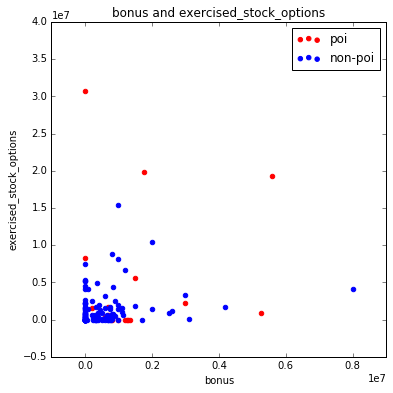

In [231]:
%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### Reassign poi index
poi_ind = features_list.index("poi")
bon_ind = features_list.index("bonus")
eso_ind = features_list.index("exercised_stock_options")

### Create arrays for salary and bonus for poi and non-poi
bon_poi     = [data[:,bon_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
eso_poi     = [data[:,eso_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
bon_nonpoi  = [data[:,bon_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
eso_nonpoi  = [data[:,eso_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

### Draw Salary histogram
plt.scatter(bon_poi,eso_poi,color="r",label="poi")
plt.scatter(bon_nonpoi,eso_nonpoi,color="b",label="non-poi")
plt.legend()
plt.xlabel("bonus")
plt.ylabel("exercised_stock_options")
plt.title("bonus and exercised_stock_options")
plt.show()

The cluster at the left bottom corner doesn't tell us much. It is difficult to identify any pattern in this cluster.

There are 4 poi at the upper right corner that are seperated from the cluster.

Now let's use these features and see how accurately they find POI's.

I will use **GaussianNB**, **DecisionTree**, **SVM**, **KNN**,  and **Logistic Regression** using various parameters.

This will be a repititive process so I will create functions for each classifiers.

## Functions of Classifiers
### Creating classify_advanced function

In [257]:
### Use GridSearchCV to find the best parameters
from sklearn.grid_search import GridSearchCV

def classify_advanced(features_list, classifiers, 
                      print_result=False, draw_graph=False):
    ### Print out features being classified
    print "Features list:", features_list[1:]
    
    ### Create an empty scores array
    scores = []
    
    ### for each classifier in classifiers calculate scores
    for classifier in classifiers:
        if classifier == "GaussianNB":
            ### set GaussianNB
            clf = GaussianNB()
            
        elif classifier == "DecisionTree":
            ### set Decision Tree
            param_grid = {
                'criterion': ['gini', 'entropy'],
                'splitter' : ['best', 'random'],
                'min_samples_split': range(2,10)
                  }
            clf = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, scoring='f1')
        
        elif classifier == "SVM":
            from sklearn import svm
            param_grid = {
                'kernel': ['rbf', 'linear', 'poly'],
                'degree': [1,2,3,4,5],
                'gamma': ['auto', 0.1, 0.3, 0.5, 0.7]
                }
            clf = GridSearchCV(svm.SVC(), param_grid, scoring='f1')
        
        elif classifier == "KNN":
            from sklearn.neighbors import KNeighborsRegressor
            param_grid = {
                'n_neighbors': [1,2,3,4,5,6,7,8,9,10],
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute']
            }
            clf = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='average_precision')
#         'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'
        elif classifier == "Logistic":
            from sklearn.linear_model import LogisticRegression
            param_grid = {
                'penalty': ['l1', 'l2'],
                'C': [.1,.3,.5,.7,.9],
                'max_iter': [1,5,10],
                'solver': ['newton-cg','lbfgs','liblinear','sag']
            }
            clf = GridSearchCV(LogisticRegression(), param_grid, scoring='f1')
        
        ### Call test function and print out test
        scores.append(test(
                features_list,clf,
                print_result=print_result, draw_graph=draw_graph, rescale=True))
    
    return scores

This function will be used whenever I check the scores for any combination of features. If I want to use GaussianNB then I just need to set 'classifiers = ["GaussianNB"]'. I can use multiple classifiers if I put 'classifiers = ["GaussianNB", "DecisionTree", "SVM"]'. In this case, the function prints out test scores for each classifier and shows the best parameter to be used.

draw_graph parameter will draw a scatter plot from test set where red shaded area predicts poi and blue shaded area predicts non-poi.

I will try to use this function with 'bonus' and 'exercised_stock_options' and see if the function works ok.

### Note On Rescale:

Another thing to note for this function is that I added scaler function in the **tester_edited.py** file. **SVM** and other classifiers are affected by the scale of the data. So rescaling the data to 0 to 1 will result in more consistent and reliable results. Below is the code in **test_classifier** function.

    if rescale:
        from sklearn.preprocessing import MinMaxScaler
        min_max_scaler = MinMaxScaler()
        features = min_max_scaler.fit_transform(features)  

rescale is a variable that takes the boolean value. If it is true then the function will rescale the features using MinMaxScaler from sklearn. I set *rescale=True* for this project for convenience.

### Bonus and Exercised Stock Options - Decision Tree

Features list: ['bonus', 'exercised_stock_options']
drawing


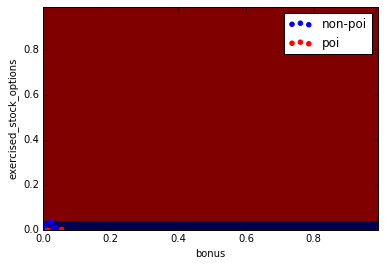


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'splitter': ['best', 'random'], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)

	Best parameters:
{'min_samples_split': 7, 'splitter': 'random', 'criterion': 'entropy'}

	Accuracy: 0.82700	Precision: 0.42243	Recall: 0.33900	F1: 0.37614	F2: 0.35294
	Total predictions: 26000	True positives: 1356	False positives: 1854	False negatives: 2644	True negatives: 20146



In [247]:
results = {}
%matplotlib inline
features = ['poi', 'bonus', 'exercised_stock_options']
classifiers = ['DecisionTree']
results["DecisionTree"] = classify_advanced(features, classifiers, print_result=True, draw_graph=True)

The function works find and the result is shown above.
- Accuracy: ~ 83.3%
- Precision: ~ 44.2%
- Recall: ~ 31.6%

*The scores will be slightly different because the algorithm randomly splits the data into test and train sets.*

Although the scores are very nice, the problem is very obvious when you look at the graph.
All of the test points are in the non-poi area and the reason why the scores could be so high is because the majority in the cluster at the left bottom corner is non-poi. So if we predict everything at these area to be non-poi then we will have pretty decent scores.

Let's try calculate scores again with different classfiers.

### Bonus and Exercised Stock Options - GaussianNB

Features list: ['bonus', 'exercised_stock_options']
drawing


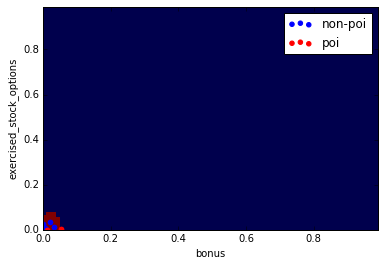


GaussianNB()

	Best parameters:
	No GridSearch

	Accuracy: 0.19708	Precision: 0.12458	Recall: 0.70000	F1: 0.21151	F2: 0.36386
	Total predictions: 26000	True positives: 2800	False positives: 19676	False negatives: 1200	True negatives: 2324



In [234]:
%matplotlib inline
features = ['poi', 'bonus', 'exercised_stock_options']
classifiers = ['GaussianNB']
results["GaussianNB"] = classify_advanced(features, classifiers, print_result=True, draw_graph=True)

GaussianNB doesn't have parameters according to the document from sklearn. So this will be the faster to run than DecisionTree or SVM.

The scores are shown above. *(The scores will be slightly different as I mentioned above.)*

- Accuracy: 19.7 %
- Precision: 12.5 %
- Recall: 70%

Although recall is quite high but other scores are pretty low because there are very few false negatives. So GaussianNB is good at identifying POI as POI. However, due to high false positives, we cannot trust the result when it says POI because a lot of them are in fact non-POIs. So GaussianNB is not a good classifier to use for these features.

### Bonus and Exercised Stock Options - SVM

Features list: ['bonus', 'exercised_stock_options']
drawing


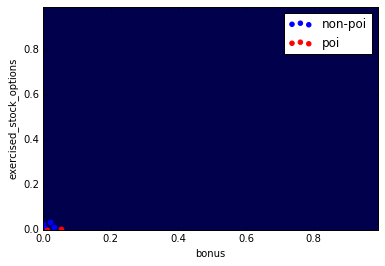

Got a divide by zero when trying out: GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'linear', 'poly'], 'degree': [1, 2, 3, 4, 5], 'gamma': ['auto', 0.1, 0.3, 0.5, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1', verbose=0)
Precision or recall may be undefined due to a lack of true positive predicitons.



In [235]:
%matplotlib inline
features = ['poi', 'bonus', 'exercised_stock_options']
classifiers = ['SVM']
results["SVM"] = classify_advanced(features, classifiers, print_result=True, draw_graph=True)

Error occurs. This error occurs when there are too many zeros. I guess SVM requires more non zero values than GaussianNB and DecisionTree. I will address this problem later.

### Bonus and Exercised Stock Options - KNN

In [ ]:
%matplotlib inline
features = ['poi', 'bonus', 'exercised_stock_options']
classifiers = ['KNN']
results["KNN"] = classify_advanced(features, classifiers, print_result=True, draw_graph=True)

Features list: ['bonus', 'exercised_stock_options']


Accuracy and precision are high but the recall is low due to high false negatives. Although KNN is not good at catching all of POIs but we can be confident that when the result shows POI than it is very likely that the person is POI.

### Bonus and Exercised Stock Options - Logistic Regression

In [ ]:
%matplotlib inline
features = ['poi', 'bonus', 'exercised_stock_options']
classifiers = ['Logistic']
results["Logistic"] = classify_advanced(features, classifiers, print_result=True, draw_graph=True)

Regression algorithm divides the area into two and assumes the left upper corner side to be POI and right bottom corner side to be non-POI. Since the algorithm gives a decimal values, I modified test_classifier function in tester_edited.py to convert decimal to 0 or 1. If the prediction is less than 0.5 then it is converted to 0. Otherwise, the prediction is converted to 1.

Accuracy is very high. But precision and recall is pretty low due to low true positives.

### Recap of Bonus and Exercised Stock Options

We found that the classify_advanced function works nicely. Although there was an error when running SVM due to a lack of non-zero values, the overall results seem to be ok. Below is the summary of the results.

In [ ]:
### Results from analysis of Bonus and Exercised Stock Options
results

**KNN** has the best accuracy and precision and **Regression** has the lowest recall. **GaussianNB** has the highest recall. **DecisionTree** is the only algorithm where every score is above 0.3. 

### Bonus and Total Stock Value

Similar to what I did before, I will plot the scatter plot for bonus and total_stock_value.

Before plotting, I will first create a function for the scatter plot because the codes will be redundant.

In [ ]:
### Set the poi_ind
poi_ind = features_list.index("poi")

%matplotlib inline
### Set the size of the plot
plt.rcParams["figure.figsize"] = (6,6)

### function for scatter plots
def scatter_plotting(x,y):
    ### Find index of x and y
    x_ind = features_list.index(x)
    y_ind = features_list.index(y)
    
    ### Create arrays for salary and bonus for poi and non-poi
    x_poi    = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    y_poi    = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    x_nonpoi = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
    y_nonpoi = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

    ### Draw Salary histogram
    plt.scatter(x_poi,   y_poi,   color="r",label="poi")
    plt.scatter(x_nonpoi,y_nonpoi,color="b",label="non-poi")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title("{} and {}".format(x, y))
    plt.show()

This function will create the scattor plot coloring poi as red and non-poi as blue.

In [ ]:
### Scatter plot between bonus and total_stock_value
scatter_plotting("bonus","total_stock_value")

The plot is similar to the scatter plot between bonus and exercised stock options. POIs are usually outside of the cluster at the left bottom corner. Due to its similarity, I expect that the scores from classifiers will be similar as well.

### Bonus and Total Stock Value - Classifiers

I am going to calculate the scores between bonus and total_stock_value from various classifiers.

I will set draw_graph to be False because I only care about scores. This will take a long time when you run because it is calculating scores using all of the classifiers.

In [ ]:
### Caclulating scores between bonus and total_stock_value
features = ['poi', 'bonus', 'total_stock_value']
classifiers = ['DecisionTree', 'GaussianNB', 'SVM', 'KNN', 'Logistic']
results = classify_advanced(features, classifiers, print_result=True, draw_graph=False)

In [ ]:
### Function for printing out results
def print_out_result(results):
    classifiers = ['DecisionTree', 'GaussianNB', 'SVM', 'KNN', 'Logistic']
    print "\n           Accuracy   Precision     Recall"
    for i in range(len(results)):
        
        print classifiers[i]
        if results[i] == None:
            print "           --------------None--------------"
        else:
            print "            {0:0.4f}      {1:0.4f}      {2:0.4f}".format(results[i][0], results[i][1], results[i][2])

In [ ]:
print_out_result(results)

The result is similar to what we saw before. SVM and Lasso provide None because they both need more non zero values for their calculations. 

Regression has the highest accuracy and lowest recall. KNN has the highest precision, GaussianNB has the highest recall and decisionTree has all the values above 0.3.

I suspect their must be a correlationship between exercised_stock_options and total_stock_value because both of them show the similar results when they are paried with bonus.

### exercised_stock_options and total_stock_value

First I will plot the scatter plot and see their relationship visually.

In [ ]:
### Scatter plot between bonus and total_stock_value
scatter_plotting("exercised_stock_options","total_stock_value")

As I expected there is a positive correlation between these two features.

Next, I will calculate the accuracy, precision and recall.

In [ ]:
### Caclulating scores between exercised_stock_options and total_stock_value
features = ['poi', 'exercised_stock_options', 'total_stock_value']
results = classify_advanced(features, classifiers, print_result=True, draw_graph=False)

In [ ]:
print_out_result(results)

The results are not very good, which means that the pair of exercised_stock_option and total_stock_value doesn't prove very insightful information for identifying POIs.

Since the scatter plot looks linear, I decided to find the correlation value between them.

### Calculating Correlation

In [ ]:
### Getting arrays
x_array = data[:, features_list.index('exercised_stock_options')]
y_array = data[:, features_list.index('total_stock_value')]

### Calculate Correlation
np.corrcoef(x_array, y_array)

The correlation between the two features is 0.9637 which is very close to 1. So they are very correlated.

And I also expect that the regression score between these two features would be very good but I am not going to calculate the number because being correlated cannot be very helpful in terms of classification.

## More plots

I will draw 5 by 3 subplots showing the scatter plots between either bonus, exercised_option_prices or total_stock_value and anything else in the features_list.

In [ ]:
%matplotlib inline
### 15 histograms for features
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(5, 3)

### the scatter plots of the data
### x: x coordinate values, y: y coordinate values
### r: row index, c: column index
### title: title of a subplot
def subplot_scatter_plot(x, y, r, c):
    ### Find index of x and y
    x_ind = features_list.index(x)
    y_ind = features_list.index(y)
    
    ### Create arrays for salary and bonus for poi and non-poi
    x_poi    = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    y_poi    = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if data[:,poi_ind][ii]]
    x_nonpoi = [data[:,x_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]
    y_nonpoi = [data[:,y_ind][ii] for ii in range(0, len(data[:,0])) if not data[:,poi_ind][ii]]

    ### Draw Salary histogram
    axarr[r,c].scatter(x_poi,   y_poi,   color="r",label="poi")
    axarr[r,c].scatter(x_nonpoi,y_nonpoi,color="b",label="non-poi")
    axarr[r,c].set_xlabel(x)
    axarr[r,c].set_ylabel(y)
    
### Setting x coordinate values and y coordinate values
x_values = ["bonus", "exercised_stock_options", "total_stock_value"]
y_values = ["salary", "restricted_stock", "expenses", "from_poi_to_this_person", "long_term_incentive"]

r = 0
c = 0
for y in y_values:
    for x in x_values: 
        subplot_scatter_plot(x,y,r,c)
        c = (c+1) % 3
    r += 1

plt.show()

Red dots are POIs and blue dots are non-POIs. I am not interested in identifying 4 POIs outside of the cluster at the left bottom corner because that can be identified very easily when I set a boundary between the cluster and outliners. What I am interested in is identifying POIs within the cluster. So I need to look for the scatter plot where red dots are close together within the cluster. A good example is a scatter plot between bonus and expense. POIs are close together and the cluster is more dispersed than other scatter plots. Another good example is scatter plot between bonus and long_term_incentive. 6 red dots are very close within the cluster.

### Creating a new feature

Based on the above plots, the blue dots have greater slopes than the red dots in the scatter plot of **exercised_stock_options** and **expenses**. I decided to create a new feature by dividing **expenses** from **exercised_stock_options** weighted by the sum of the squares of these features to the power of 0.2. I used the power of 0.2 to get a better distribution.

In [ ]:
### Creating a new feature - eso_expenses
tmp_array = np.empty([len(data[:,0]),1])
for i in range(len(data[:,0])):
    ex = data[i,features_list.index("expenses")]
    eso = data[i,features_list.index("exercised_stock_options")]
    
    ### If both values are zero then set it 0
    if ex * eso == 0:
        tmp_array[i,0] = 0
    else:
        tmp_array[i,0] = eso / ex * (ex*ex + eso*eso)
        
### Print out the original size of data
print "Before append:", data.shape

### Find max and min of the new feature
new_feature_max = np.max(tmp_array)
new_feature_min = np.min(tmp_array)

print "Max:", new_feature_max
print "Min:", new_feature_min


### Append the new feature column to data numpy array
if len(data[0,:]) == 10:
    ### To prevent appending a column again when rerunning the code
    for i in range(len(tmp_array)):
#         if np.log(tmp_array[i]) < 0:
#             data[i,-1] = 0
#         else:
        data[i,-1] = np.power((tmp_array[i]-new_feature_min) / (new_feature_max - new_feature_min), .2)
else:
    data = np.append(data, tmp_array, axis= 1)

### Print out the size of appended data
print "After append:", data.shape

### Add new feature to features_list
if features_list[-1] != "eso_expenses":
    features_list.append("eso_expenses")

The code above appends the new feature to the existing data numpy array. In the code I set the new feature's value equal to 0 when the denominator is zero or the numerator is zero to avoid having *inf* values.

Then I scaled the new feature to 0 to 1.

### Plotting a new feature

In [ ]:
### Draw eso_expenses histogram
plt.hist(data[:,features_list.index("eso_expenses")], bins=100)
plt.xlabel("eso_expenses")
plt.ylabel("count")
plt.title("eso_expenses Histogram")
plt.show()

### Scatter plot between bonus and total_stock_value
scatter_plotting("eso_expenses","eso_expenses")

The histogram shows that the majority of values of the new features are zeros. The second scatter plot is showing the distribution of the new feature colored by poi and non-poi.

### Calculating the scores - OLD VERSION - DELETE!!!

I am going to calculate the scores of each pair of features that is being plotted above.

After I am done calculating all of them, I will choose the pairs of features showing the best scores.

**Note:**

Initially I tried to calculate the scores of 15 paris using 6 classifiers, but it takes a tremendously huge amount of time and it never ends. So I decided to calculate them using only 2 classifiers: DecisionTree and GaussianNB. Although the other classifiers such as KNN shows the higher accuracy than these two, I chose these two because they show well-rounded results while KNN and others showed recall less than 10%.

In [ ]:
### WARNING: THIS TAKES A LOT OF TIME. DO NOT RUN IT IF POSSIBLE.

### Caclulating scores
x_values = ["bonus", "exercised_stock_options", "total_stock_value"]
y_values = ["salary", "restricted_stock", "expenses", "from_poi_to_this_person", "long_term_incentive"]

classifiers = ["DecisionTree", "GaussianNB"]
results_list = []
for y in y_values:
    for x in x_values:
        features = ['poi', x, y]
        results = classify_advanced(features, classifiers, print_result=True, draw_graph=False)
        results_list.append(results)

In [ ]:
### Printing out the result in a more readable format
for results in results_list:
    print_out_result(results)

I didn't add the features being used in the results array so the print out function cannot print out the names of features being scored. However, we can find out the features very easily by looking at the output from the previous code or we can look at the order it appears on this results.

I am going to chose three pairs of features: one with the highest accuracy, one with the highest precision and one with the highest recall.

**The highest accuracy :** **0.8296** by DecisionTree from 'exercised_stock_options' and 'restricted_stock'

**The highest precision:** **0.3975** by DecisionTree from 'bonus' and 'expenses'

**The highest recall   :** **0.8560** by GaussianNB from 'bonus' and 'expenses'

So here are my combinations that I will be using for the multivariate analysis:

- bonus
- exercised_stock_options
- total_stock_value
- restricted_stock
- expenses

# Multivariate Analysis

This will be the final round of achieving the highest scores from the data set. So far I conducted a univariate analysis to find the single features having the highest scores and then through the bivariate analysis I found the pair of combinataions showing the best result for accuracy, precision and recall.

I will run the "classify_advanced" function on these 5 features and check the scores. I am not 100% certain that the scores will be better than the grades I've seen so far. For example, when you look at the pair of bonus and expense it shows the highest recall but shows very low accuracy and precision.

In [ ]:
### Calculating the scores using my top features
classifiers = ['DecisionTree', 'GaussianNB', 'SVM', 'KNN', 'Logistic']
features = ['poi', 'bonus', 'exercised_stock_options', 'total_stock_value', 'restricted_stock', 'expenses']
results = classify_advanced(features, classifiers, print_result=True, draw_graph=False)

In [ ]:
### Print results
print_out_result(results)

Similar to the other results, decision tree again shows the most well rounded result. However, recall value is slightly less than 0.3

So the result is not as good as the one we saw before. Using more features doesn't necessarily mean the better scores. I will use bonus and exercised_stock_options as my final choice of combination for identifying POIs. The accuracy, precision and recall are all above 0.3 when classfied with DecisionTree.

# Final Thought

For this final project, I first investigated the overall data set first. I checked the number features in the data set, the number of POIs, and see if there are any features with too many zeros or missing values. Then, I found an outlier and realized that there was “Total” summing all the features in the data set. I got rid of this “Total” and the data showed better plots. I created a function that splits the data using **StratifiedShuffleSplit** cross validation that is being used in *tester.py*.  I thought this is the best cross validation to be used because it increases the size of the data points randomly and provides the better calculation. Due to small number of POIs in the data set, Test and Train split can cause zero POI in test set very frequently, so it won’t give very good calculation.

I created a function that can calculate accuracy, precision and recall using various classifiers with the best parameters (the parameters are chosen by **GridSearchCV**) and as a result, the best combination of features to identify the POIs are bonus and exercised_stock_options with DecisionTree classifier.

During the process, SVM and Lasso Regression result in error most of the time due to lack of non-zero values in the input data set. This can be fixed by using **StratifiedShuffleSplit** and increase the number of data points, but I didn’t do it because this will take too much amount of time. 

I believe that there are many ways of improving my result. Assuming I have a lot of time, I can try more parameters of classifiers. And I can also use more parameters in **GridSearchCV**. For example there is “cv” parameter that can specify the number of folds. This “cv” parameter can fix the problem I encountered above as well.


** Note: ** 
*poi_id.py* includes the result with the best scores from my investigation and it can be tested by running *tester.py*.

 